#Topic 3: Comparing the performance of dealing with outliers between linear regression and three robust linear regression models: RANSAC regression, Theil-Sen regression, and Huber regression
## Statistical Foundations of Machine Learning
### ETRO: Deparment of Electronics and Informatics
### Vrije Universiteit Brussel

<font color=blue>Student name and ID: </font> Weilun Chen(0594661)<Br>
<font color=blue>Student name and ID: </font> Weiyi Wang(0595445)<Br>
<font color=blue>Student name and ID: </font> Siyan Luo(0594750)<Br>
<font color=blue>Master Program: </font> All three students are from Master of Applied Computer Science<Br>
<font color=blue>Academic Year: </font> 2022-2023

Comparing the performance of dealing with outliers between linear regression and three robust linear regression models: RANSAC regression, Theil-Sen regression, and Huber regression [[1]](https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/)



### **Introduction**

Most regression algorithms assume that the relationship between the input variables and the target variables is linear, such as a line in 2D. Linear regression assumes the residuals are well behaved, such as following a Gaussian distribution. However, when there are outliers in the dataset, the obeservations will be different from the expected distribution [[2]](https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/).

An outlier is an object that deviates significantly from the rest of the objects.[[3]](https://www.geeksforgeeks.org/machine-learning-outlier/) 

The presence of outliers results in prolonged training times, and the development of less precise models. [[4]](https://www.expressanalytics.com/blog/outliers-machine-learning/#:~:text=Dealing%20With%20Outliers%20In%20Data%20using%20Machine%20Learning&text=An%20outlier%20is%20a%20data,considered%20when%20collecting%20the%20data.)

Such that more robust models are needed in the case of outliers. In regression algorithm, robust linear regression was introduced, which is a method of regression analysis which is less sensitive to outliers in the data than traditional linear regression.

In this expirement, we discovered the performance of three robust linear regression models compared with linear regression.

### **Dataset generation**

First, import all the packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn import datasets

Here I used a synthetic dataset. 

Generate a linear dataset of 300 samples using [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function. This dataset was splitted into training set of 225 data points and testing set of 75 data points. To guarantee the same result at every run, random state was setted.

True coefficients: 28.203457257130648


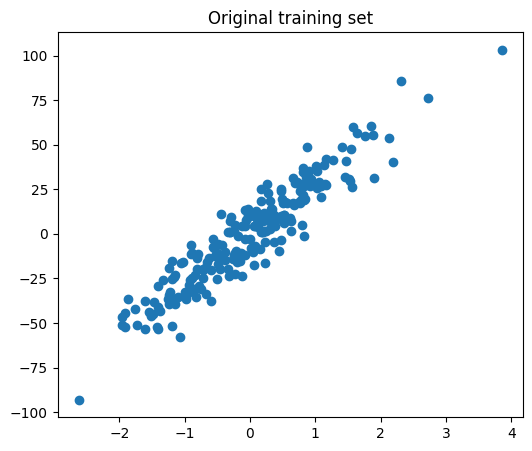

In [ ]:
samples = 300
X, y, coef = make_regression(n_samples = samples, n_features=1, n_informative = 1, noise=10, random_state = 42, coef=True)
print("True coefficients:", coef)
# split the dataset as training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# convert 2D np array to list
X_train = sum(X_train.tolist(), [])
# convert np array to list
y_train = y_train.tolist()
# plot the training set
fig = plt.figure(figsize = (6, 5))
plt.scatter(X_train, y_train)
plt.title("Original training set")
plt.show()

Add outliers: add 25 extreme values to the training set as outliers, using [uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to randomly choose a specific number of points within specific range. It made the training set contains 250 data ponits in total among which 25 ponits are outliers.


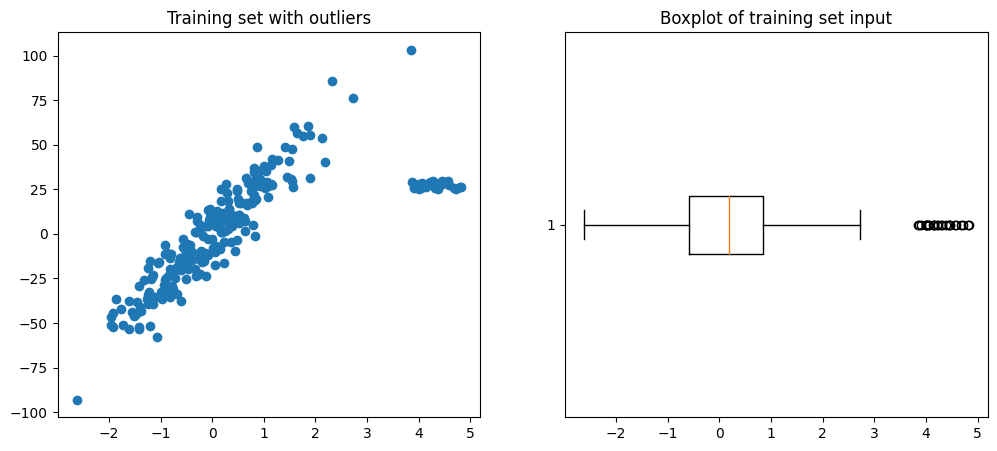

In [ ]:
# set random seed to guarantee the repeatability
np.random.seed(42)

num_outliers = 25
X_outliers= np.random.uniform(max(X_train), max(X_train)+1, num_outliers).tolist()
y_outliers = np.random.uniform(25, 30, num_outliers).tolist()

# concarenate outliers with original training set
X_train = np.concatenate((X_train, X_outliers))
y_train = np.concatenate((y_train, y_outliers))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_train, y_train)
axs[0].set_title("Training set with outliers")
axs[1].boxplot(X_train, vert=False)
axs[1].set_title("Boxplot of training set input")
plt.show()

Reshape the datasets

In [ ]:
X_train = np.array(X_train).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1).ravel()

## **Modeling**

### **Linear regression**
Linear regeression assumes a linear relationship between the variables. 

The algorithm works as followed [[5]](https://towardsai.net/p/machine-learning/linear-regression-complete-derivation-with-mathematics-explained).

1) Given n inputs and targets

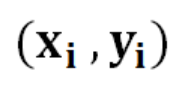

2) Define the best fit line as:

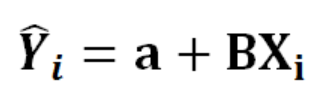

3) The sum of squared residuals, also knowned ad the error function named S is: 

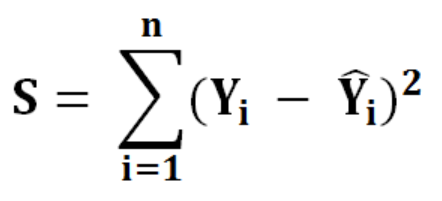

4) Utilize the formula in 2), we got:

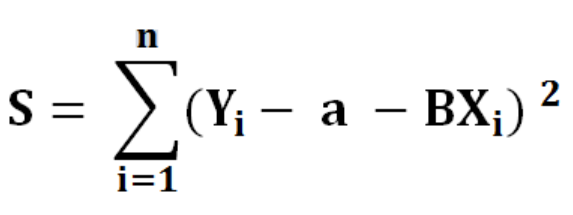

This algorithm aims at estimating the values of a and B that minimize the error function.



Linear Regression coefficients: 13.514856095369804


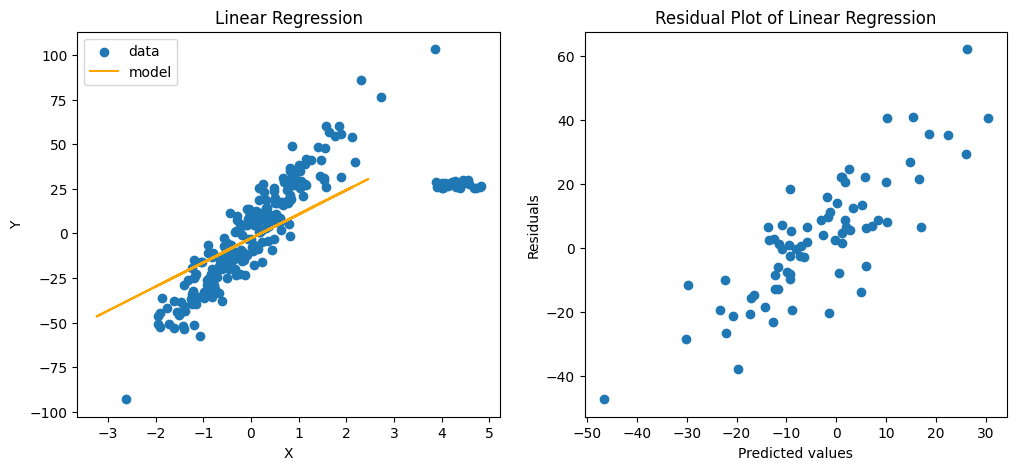

In [ ]:
linear = LinearRegression().fit(X_train, y_train)

print("Linear Regression coefficients:", linear.coef_[0])

y_pred_l = linear.predict(X_test)
residuals_l = y_test - y_pred_l

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_train, y_train, label='data')
axs[0].plot(X_test, y_pred_l, color='orange', label='model')
axs[0].legend(loc='upper left')
axs[0].set_xlabel("X")
axs[0].set_ylabel('Y')
axs[0].set_title("Linear Regression")

axs[1].scatter(y_pred_l, residuals_l)
axs[1].set_xlabel('Predicted values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot of Linear Regression')

plt.show()


### **RANSAC Regression**

RANSAC(RANdom SAmple Consensus) algorithm is an extensiom of linear regression to improve the robustness by excluding the outliers in the training dataset.

The workflow of RANSAC is as follows [[6]](https://vitalflux.com/ransac-regression-explained-with-python-examples/):
1. Select a random number of examples to be inliers and train the model.
2. Test all other data points against the trained model
3. Out of all the data points tested in step 2, select the points as inliers which fall within a user-given tolerance. In scikit-learn, median absolute deviation (MAD) is used, which is measure of variability of observations from the median value of the observation. 

  MAD = Median(|Xi - median(X)|)

  Where Xi represents each data point, median(X) represents the median value.

4. Retrain the model with all inliers data
5. Estimate the error of the retrained model versus the inliers.
6. Follow step 1 to step 5
7. Terminate the algorithm execution if the model performance meets a certain user-defined threshold or if a fixed number of iterations were reached

The advantages of RANSAC algorithm includes that it takes care of removing outliers from the training data set while fitting the model.


RANSAC coefficients: 29.08034884765279


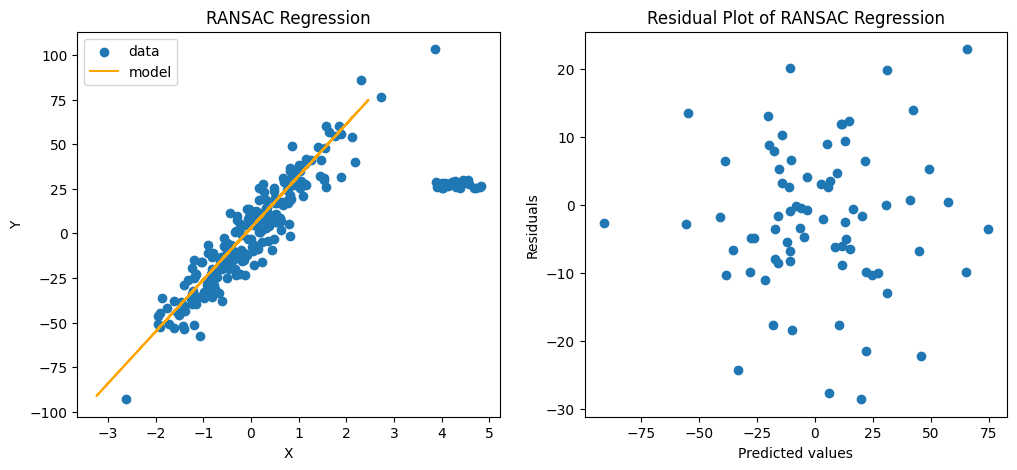

In [ ]:
ransac = RANSACRegressor(random_state=42).fit(X_train, y_train)

print("RANSAC coefficients:", ransac.estimator_.coef_[0])

y_pred_r = ransac.predict(X_test)
residuals_r = y_test - y_pred_r

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_train, y_train, label='data')
axs[0].plot(X_test, y_pred_r, color='orange', label='model')
axs[0].legend(loc='upper left')
axs[0].set_xlabel("X")
axs[0].set_ylabel('Y')
axs[0].set_title("RANSAC Regression")

axs[1].scatter(y_pred_r, residuals_r)
axs[1].set_xlabel('Predicted values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot of RANSAC Regression')

plt.show()


### **Theil-Sen Regression**

Compared to linear regression, the Theil-Sen estimator is robust against outliers like RANSAC.

The workflow of Theil-Sen regression algorithm is as follows [[7]]( https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html) :

1. Calculate the slopes between each pair of points in the data. (For a pair of points, (xi, yi) and (xj, yj), the slope is calculated as (yj–yi)/(xj–xi) if xi ≠ xj.) [[8]](https://data.library.virginia.edu/theil-sen-regression-programming-and-understanding-an-outlier-resistant-alternative-to-least-squares/)

2. Sort the calculated slopes in ascending order. 
3. The final slope is then defined as the spatial median of these slopes .

The Theil-Sen regression estimator is resistant to the presence of outliers because it is based on the median of the slopes rather than the mean. The median is less sensitive to extreme values, making it a robust measure of central tendency. 

However, Theil-Sen estimator has a breakdown point of 29.3%. It can tolerate up to 29.3% of the input data being outliers, otherwise the slope estimate can become arbitrarily large in magnitude.

TheilSen coefficients: 24.71928201456444


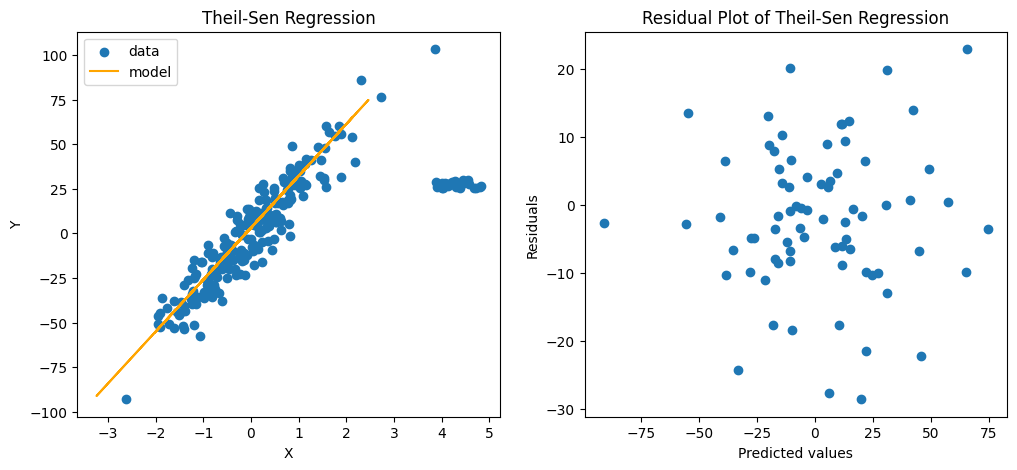

In [ ]:
theil = TheilSenRegressor(random_state=42).fit(X_train, y_train)

print("TheilSen coefficients:", theil.coef_[0])

y_pred_t = theil.predict(X_test)
residuals_t = y_test - y_pred_t

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_train, y_train, label='data')
axs[0].plot(X_test, y_pred_r, color='orange', label='model')
axs[0].legend(loc='upper left')
axs[0].set_xlabel("X")
axs[0].set_ylabel('Y')
axs[0].set_title("Theil-Sen Regression")

axs[1].scatter(y_pred_r, residuals_r)
axs[1].set_xlabel('Predicted values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot of Theil-Sen Regression')

plt.show()

### **Huber regression**

Compared to linear regression, Huber regression optimized the loss function [[9]](https://towardsdatascience.com/regression-in-the-face-of-messy-outliers-try-huber-regressor-3a54ddc12516).

The loss function of Huber regression is:

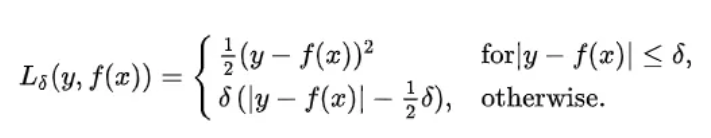

The loss is the half of the square of the usual residual (y-f(x)) only when the absolute value of the residual is smaller than the threshold called Huber parameter. When the residual is larger than the threshold, the loss is a function regarding the absolute value of the residual and the Huber parameter. 

Squared loss is centered around the mean while absolute value loss is centered around the median. The median is less influenced by extreme values or outliers compared to the mean. Because in median value calculation, only the order of the data points is considered, not the specific values. However, When calculating the mean value, the actual values of all data points are taken into account.

Huber loss strikes a balance between squared loss and absolute value loss. It is more robust to the outliers than linear regression but it does not completely ignore them either.

Huber coefficients: 24.71928201456444


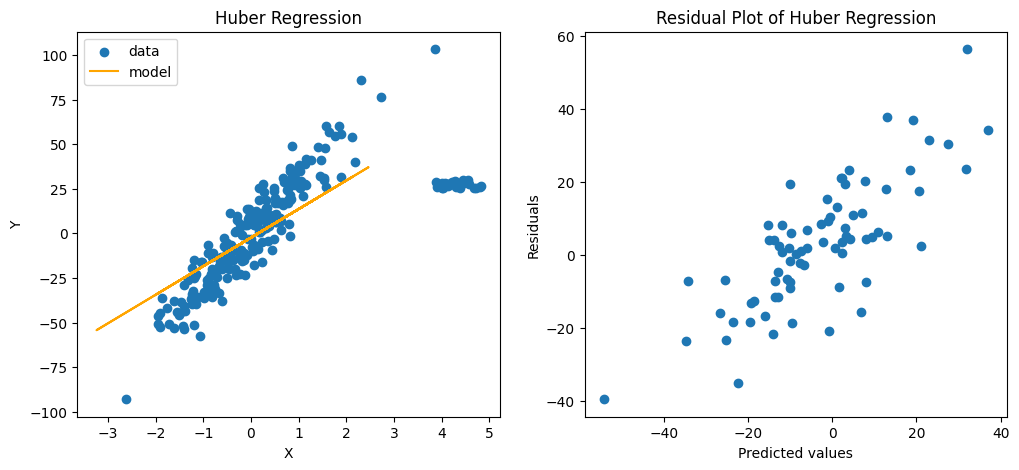

In [ ]:
huber = HuberRegressor().fit(X_train, y_train)

print("Huber coefficients:", theil.coef_[0])

y_pred_h = huber.predict(X_test)
residuals_h = y_test - y_pred_h

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(X_train, y_train, label='data')
axs[0].plot(X_test, y_pred_h, color='orange', label='model')
axs[0].legend(loc='upper left')
axs[0].set_xlabel("X")
axs[0].set_ylabel('Y')
axs[0].set_title("Huber Regression")

axs[1].scatter(y_pred_h, residuals_h)
axs[1].set_xlabel('Predicted values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot of Huber Regression')

plt.show()

## **Model Evaluation**

To evaluate the performance of regression models, Mean Squared Error (MSE) and Coefficient of Determination (r2) are calculated.

MSE assesses the average squared difference between actual values and predicted values. As the model error increases, MSE value increses [[10]](https://statisticsbyjim.com/regression/mean-squared-error-mse/).

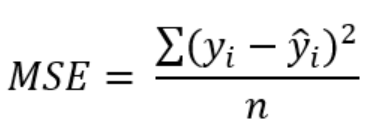

Above is the formula of MSE, where n is the number of data points, yi is the actual value, ŷi is the predicted value.

r2 measures how close the data points are to the fitted line[[11]](https://vitalflux.com/r-squared-explained-machine-learning/#:~:text=In%20linear%20regression%2C%20R%2Dsquared,as%20the%20coefficient%20of%20determination.) It is defined as the proportion of variation of data points explained by the regression model. It can be calculated as a function of the sum of squared residuals and the total variation of data points from the mean. The formula is following.

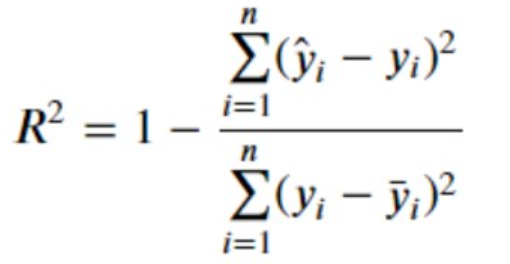

yi is the actual value, ŷi is the predicted value, and yi_bar is the mean of all the values





In [ ]:
pred = [y_pred_l, y_pred_r, y_pred_t, y_pred_h]
mse = []
r2 = []
for i in pred:
  mse.append(np.round(mean_squared_error(y_test, i), 2))
  r2.append(np.round(r2_score(y_test, i), 2))

## **Result**

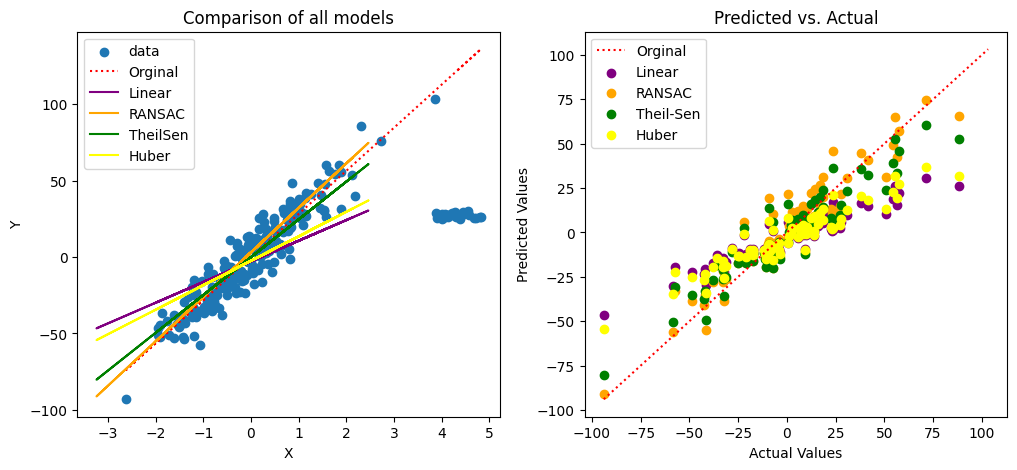

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# fig = plt.figure(figsize = (6, 5)
axs[0].scatter(X_train, y_train, label='data')
axs[0].plot(X_train[:,0], coef*X_train[:,0], color='red', label = 'Orginal', linestyle='dotted')
axs[0].plot(X_test, y_pred_l, color='purple', label='Linear')
axs[0].plot(X_test, y_pred_r, color='orange', label='RANSAC')
axs[0].plot(X_test, y_pred_t, color='green', label='TheilSen')
axs[0].plot(X_test, y_pred_h, color='yellow', label='Huber')
axs[0].legend(loc='upper left')
axs[0].set_title("Comparison of all models")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")

# Plot the ideal line (y = x)
axs[1].plot([min(y), max(y)], [min(y), max(y)],  label = 'Orginal', linestyle='dotted', color='red')
axs[1].scatter(y_test, y_pred_l, color='purple', label='Linear')
axs[1].scatter(y_test, y_pred_r, color='orange', label='RANSAC')
axs[1].scatter(y_test, y_pred_t, color='green', label='Theil-Sen')
axs[1].scatter(y_test, y_pred_h, color='yellow', label='Huber')
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Predicted vs. Actual')
axs[1].legend(loc='upper left')

plt.show()


In [ ]:
model_names = ["Original Dataset"
              , "Linear Regression"
              , "RANSAC Regressor"
              , "TheilSen Regressor"
              , "Huber Regressor"
              ]

coefs = [coef, linear.coef_[0]
         , ransac.estimator_.coef_[0]
         , theil.coef_[0]
         , huber.coef_[0]
         ]

for i in range(len(coefs)):
  coefs[i] = np.round(coefs[i], 2)

mse.insert(0, 'Null')
r2.insert(0, 'Null')

result = {'Model_Name': model_names
          , "Coefficient ":coefs
          , "Mean_Squared_Error": mse
          , "Coefficient_of_Determination": r2
        }

output = pd.DataFrame(result)

output.head()

,Model_Name,Coefficient,Mean_Squared_Error,Coefficient_of_Determination
0,Original Dataset,28.20,Null,Null
1,Linear Regression,13.51,376.07,0.62
2,RANSAC Regressor,29.08,116.13,0.88
3,TheilSen Regressor,24.72,134.66,0.86
4,Huber Regressor,16.01,300.53,0.69


As we could tell from the results. All three robust regression models are less sensitive to outliers than linear regression. Among robust regression models, RANSAC regressor delivered the best performance while Huber regressor performed the worst in terms of the coefficient, mean squared error, and coefficient of determination.The reason might related to the underlying algorithms, since the implementation of Huber doesn't filter out all the ourliers but decreases their effect.

## **Conclusion**

In the presence of outliers, RANSAC regressor, Theil-Sen regressor, and Huber regressor show much better performance than classic linear regression, while Huber regressor is less robust.

RANSAC regression algorithm takes care of removing outliers from the training data set while fitting the model.

Theil-Sen regression algorithm estimates the slope by calculating the median of all possible pairwise slopes between the data points.

Huber regression algorithm combines squared error loss for small errors and absolute error loss for large errors, using a specified threshold to balance between the two.